# Progetto Introduzione all'intelligenza artificiale

Il progetto consiste nella realizzazione di una applicazione di Intelligenza Artificiale completa degli
aspetti di gestione di: sensori per l’acquisizione dei dati dall’esterno relativi a stati e obiettivi,
ragionamento/ricerca della soluzione per i goal acquisiti, esecutori per la realizzazione delle azioni
che conducono alla soluzione.

## Progetto Uniform Coloring
Uniform Coloring è un dominio in cui si hanno a disposizione alcune celle da colorare, e vari colori a disposizione. 
Per semplicità immaginiamo una griglia rettangolare in cui è possibile spostare una testina colorante fra le celle attigue secondo le 4 direzioni cardinali (N,S,E,W), senza uscire dalla griglia. 

Tutte le celle hanno un colore di partenza (B=blu, Y=yellow, G=green) ad eccezione di quella in cui si trova la testina indicata con T. La testina può colorare la cella in cui si trova con uno qualsiasi dei colori disponibili a differenti costi (cost(B)=1, cost(Y)=2, cost(G)=3), mentre gli spostamenti hanno tutti costo uniforme pari a 1. 

>L’obiettivo è colorare tutte le celle dello stesso colore (non importa quale) e riportare la testina nella sua posizione di partenza.

La codifica di tutto il dominio (topologia della griglia, definizione delle azioni etc.) è parte dell’esercizio. Partendo dalla posizione iniziale della testina e combinando azioni di spostamento e colorazione, si chiede di trovare la sequenza di azioni dell’agente per raggiungere l’obiettivo.

La posizione iniziale della testina, la struttura della griglia e la colorazione iniziale delle celle sono passati al sistema tramite un’immagine.

### Inizializzazione delle librerie e moduli

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
from emnist import list_datasets
from tensorflow import keras    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report



list_datasets()

'''
# print some images from the dataset to test
import matplotlib.pyplot as plt
from emnist import extract_training_samples
images, labels = extract_training_samples('letters')
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray')
plt.show()
'''


"\n# print some images from the dataset to test\nimport matplotlib.pyplot as plt\nfrom emnist import extract_training_samples\nimages, labels = extract_training_samples('letters')\nfor i in range(100):\n    plt.subplot(10, 10, i+1)\n    plt.axis('off')\n    plt.imshow(images[i], cmap='gray')\nplt.show()\n"

## 1. Descrizione formale del dominio e vincoli su cui l'agente può operare

Descrizione formale del dominio e dei vincoli che le azioni eseguibili dall’agente (la testina) nella griglia devono rispettare (esempio vincoli: v1=”l’agente può compiere un solo passo alla volta”, v2=”l’agente si può muovere solo fra celle adiacenti”, etc.). La descrizione sarà un testo che descrive le regole da rispettare e le assunzioni desunte dall’analisi del dominio.

### Descrizione del dominio e vincoli 

**Elementi del dominio:**
- Celle: Presenti in una griglia rettangolare nella quale è possibile spostare una testina colorante. Ogni cella ha un colore di partenza ed è possibile ricolorarle con i tre colori disponibili (yellow, blue, green).
- Testina colorante: È l'agente che, nella griglia fornita in input come immagine, può spostarsi tra le celle e cambiarne il colore. Una delle celle rappresenta la posizione iniziale della testina prima di muoversi e sulla quale dovrà ritornare dopo aver svolto le azioni richieste.

**Relazioni:**
- Ad ogni cella dell'immagine è associata un'etichetta rappresentante uno dei colori disponibili (Y, B, G).
- La testina inizialmente dovrà essere posizionata sempre sulla cella con etichetta T.

**Regole:**
- La testina può spostarsi nelle sole direzioni nord, sud, est, ovest.
- La testina può cambiare colore nella cella in cui è posizionata. Colorare le celle ha un costo che varia in base al colore (cost(B) = 1, cost(Y) = 2, cost(G) = 3).
- Il passaggio da una cella all'altra ha sempre costo 1.
- **GOAL**: Colorare tutte le celle dello stesso colore. La testina dovrà trovare un modo per farlo nella maniera più efficiente possibile, sia in termini di colori che di numero di passi effettuati per muoversi tra le celle.

**Vincoli:**
- v0="La griglia può essere rettangolare e quadrata".
- v1=”L’agente può compiere un solo passo alla volta”.
- v2=”L’agente si può muovere solo fra celle adiacenti”.
- v3="Nella griglia non esistono celle vuote, tutte devono essere colorate in partenza".
- v4="Le celle devono essere tutte raggiungibili dalla posizione iniziale della testina".
- v5="Il costo delle azioni di movimento è uniforme (1), mentre il costo della colorazione dipende dal colore scelto".
- v6="L'agente non può colorare la posizione di partenza (quindi bisogna trovare un modo per evitarlo)".
- v7="Dopo che l'agente ha colorato tutte le celle, deve ritornare alla posizione di partenza".

**Esempi di problemi, con possibili soluzioni e costi**:
che sono costituite da un array bidimsionale, verranno fornite in un immagine come input al programma  

I vincoli applicati sono i seguenti:
- v1=”l’agente può compiere un solo passo alla volta”
- v2=”l’agente si può muovere solo fra celle adiacenti”
- v3="dopo che l'agente ha colorato tutte le testine, deve ritornare alla posizione di partenza"
- v4="l'agente non puo colorare la posizione di partenza (quindi bisogna trovare un modo per evitarlo)"

## 2 Implementazione delle classi per la ricerca nello spazio degli stati di Smart Vacuum.
Utilizzando le classi di AIMA-python si implementi quindi un dominio UniformColoring come classe derivata da Problem, scegliendo e definendo una rappresentazione per gli stati e ridefinendo opportuni metodi actions e result e tutti gli eventuali metodi aggiuntivi , es. goal_test, che si rendessero necessari.
Si descriva e si implementi almeno una euristica definenendone le caratteristiche di consistenza e ammissibilità rispetto al dominio dato. L’euristica definita mantiene le stesse proprietà nel caso in cui le azioni di spostamento costassero 0 o le colorazioni avessero tutte lo stesso costo?

## 3 Acquisizione e classificazione degli input, stato iniziale e goal. 
Si realizzi un programma che, passata in input un’immagine contenente la configurazione della griglia e la posizione iniziale dell’agente:
a) interpreti l’immagine individuando la configurazione della griglia e, attraverso un metodo di classificazione, la posizione iniziale dell’agente e la colorazione iniziale delle celle. Non ci sono vincoli sul metodo/modello utilizzato per la classificazione. 
Si consiglia di utilizzare il dataseteMNIST/MNIST per la classficazione di lettere e cifre scritte a mano, visto a lezione e facilmente reperibile su Web. Assumiamo che le lettere siano solo maiuscole;
b) traduca i dati risultanti dall’analisi delle immagini negli stati stato_iniziale e stato_goal del problema, secondo la rappresentazione definita per il punto 2;
c) invochi il solutore (vedi punto 2), tramite una tecnica di ricerca informata e almeno una non informata, della classe UniformColoring e produca, se esiste, la soluzione del problema, ovvero la sequenza azioni da eseguire per raggiungere lo stato goal. E’ interessante mostrare come algoritmi diversi possano portare a soluzioni diverse nel caso in cui ottimizzino rispetto al costo della soluzione oppure rispetto la sua lunghezza.

In [19]:
# Import the necessary functions from the emnist library
from emnist import extract_training_samples
from emnist import extract_test_samples

# Define the labels for the EMNIST dataset
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

# Define a function to remodulate the labels
def remodulate(y):
    """
    Remodulates the input array 'y' based on the labels.

    Parameters:
    - y (numpy.ndarray): The input array to be remodulated.

    Returns:
    - numpy.ndarray: The remodulated array.
    """
    # Replace the labels 'T', 'B', 'Y', 'G' with 0, 1, 2, 3 respectively
    # Define a dictionary to map the labels to their new values
    label_map = {"T": 0, "B": 1, "Y": 2, "G": 3}

    # Loop through the label_map to replace the labels with their new values
    for label, value in label_map.items():
        y = np.where(y == LABELS.index(label), value, y)

    return y

# Define a function to filter the dataset based on specific label conditions
def filterDataset(X_data, y_data):
    """
    Filters the dataset based on lables we need to use (T, B, G, Y).

    Args:
        X_data (ndarray): Input data array of shape (n_samples, 28, 28).
        y_data (ndarray): Target labels array of shape (n_samples,).

    Returns:
        tuple: A tuple containing the filtered input data array and target labels array.

    Raises:
        AssertionError: If the dtype of y_data is not np.uint8.
    """
    # Assert that the dtype of y_data is np.uint8
    assert y_data.dtype == np.uint8
    # Define the classes
    classes = LABELS
    # Initialize the new_data_size
    new_data_size = 0
    # Initialize the new_data_index
    new_data_index = 0

    # Loop through the y_data to count the number of records with labels 'B', 'Y', 'G', 'T'
    for recordIndex in range(0, y_data.shape[0]):
        currentLabel = classes[y_data[recordIndex]]
        if currentLabel == 'B' or currentLabel == 'Y' or currentLabel == 'G' or currentLabel == 'T':
            new_data_size += 1
    
    # Initialize the new_X_data and new_y_data with zeros
    new_X_data = np.zeros((new_data_size, 28, 28), dtype = X_data.dtype)
    new_y_data = np.zeros((new_data_size,), dtype = np.uint8)

    # Loop through the y_data to filter the records with labels 'B', 'Y', 'G', 'T'
    for recordIndex in range(0, y_data.shape[0]):
        currentLabel = classes[y_data[recordIndex]]

        if currentLabel != 'B' and currentLabel != 'Y' and currentLabel != 'G' and currentLabel != 'T':
            continue
        
        new_X_data[new_data_index] = X_data[recordIndex]
        new_y_data[new_data_index] = y_data[recordIndex]
        new_data_index += 1
    
    # Assert that the new_data_index is equal to the shape of new_X_data
    assert new_data_index == new_X_data.shape[0]
    return (new_X_data, new_y_data)

# Extract the training and test samples from the EMNIST dataset
X_train, y_train = extract_training_samples('balanced')
X_test, y_test = extract_test_samples('balanced')

# Filter the training and test datasets
(X_train, y_train_library) = filterDataset(X_train, y_train)
(X_test, y_test) = filterDataset(X_test, y_test)

# Remodulate the labels of the training and test datasets
y_train_library = remodulate(y_train_library)
y_test = remodulate(y_test)

# Normalize the training and test datasets
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

KeyError: "There is no item named 'gzip/emnist-balanced-train-images-idx3-ubyte.gz' in the archive"

### Reshape
Il seguente codice sta ridisponendo i dati di addestramento e test _da 3D_ (numero di campioni, larghezza dell'immagine, altezza dell'immagine) _a 2D_ (numero di campioni, larghezza dell'immagine * altezza dell'immagine).
Molti modelli di reti neurali si aspettano di ricevere dati in un formato bidimensionale, quindi se i tuoi dati sono in un formato diverso (ad esempio, immagini rappresentate come array tridimensionali), potrebbe essere necessario eseguire il reshape per adattarli alla forma richiesta dal modello..

In [3]:
# Print the shape of the training data
print(X_train.shape)

# Reshape the training data from 3D to 2D. The new shape is (number of samples, image width * image height)
X_train = X_train.reshape((-1, 28, 28, 1))

# Reshape the test data from 3D to 2D. The new shape is (number of samples, image width * image height)
X_test = X_test.reshape((-1, 28, 28, 1))

# Print the new shape of the training data
print(X_train.shape)

# Print the shape of the test data
print(X_test.shape)

(9600, 28, 28)
(9600, 28, 28, 1)
(1600, 28, 28, 1)


### Creazione della rete neurale per il modello 

In [12]:
'''
# Initialize a Sequential model
seq_lett_model = keras.Sequential()

# Add an Input layer to the model. This layer specifies the shape of the input data (784 features).
seq_lett_model.add(keras.Input(shape=(784,)))

# Add a Dense layer to the model with 256 neurons and a ReLU activation function.
# Dense layers are fully connected layers, meaning all the neurons in a layer are connected to those in the next layer.
seq_lett_model.add(keras.layers.Dense(512, activation='relu'))

# Add another Dense layer to the model with 128 neurons and a ReLU activation function.
seq_lett_model.add(keras.layers.Dense(256, activation='relu'))

# Add a final Dense layer with 4 neurons (because we have 4 letters to detect) and a softmax activation function.
# The softmax function is often used in the final layer of a neural network-based classifier.
seq_lett_model.add(keras.layers.Dense(4, activation='softmax'))

# Print a summary of the model, including the number of parameters and the shape of the output at each layer.
'''
seq_lett_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # Input shape: 28x28 pixels, 1 color channel
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  # Output layer for 4 letters
])

seq_lett_model.summary()

/home/toita/Documents/progetto-intro-ia/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,932 (363.02 KB)

 Trainable params: 92,932 (363.02 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [13]:
# Set the batch size. This is the number of samples that will be passed through the network at once.
batch_size = 384

# Set the number of epochs to 7. An epoch is one complete pass through the entire training dataset.
epochs = 10

# Compile the model. 
# We use the sparse_categorical_crossentropy loss function, which is suitable for multi-class classification problems.
# The optimizer is set to 'adam', which is a popular choice due to its efficiency and good performance on a wide range of problems.
# We also specify that we want to evaluate the model's accuracy during training.
seq_lett_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data. 
# We also specify a validation split of 0.1, meaning that 10% of the training data will be used as validation data.
# The model's performance is evaluated on this validation data at the end of each epoch.
training_operation = seq_lett_model.fit(X_train, y_train_library, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Save the trained model to a file so that it can be loaded later for making predictions or continuing training.
seq_lett_model.save('seq_lett_model.keras')

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6230 - loss: 0.9768 - val_accuracy: 0.9208 - val_loss: 0.2050
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9270 - loss: 0.1954 - val_accuracy: 0.9698 - val_loss: 0.0961
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9656 - loss: 0.1081 - val_accuracy: 0.9760 - val_loss: 0.0701
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9767 - loss: 0.0724 - val_accuracy: 0.9844 - val_loss: 0.0469
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9803 - loss: 0.0553 - val_accuracy: 0.9885 - val_loss: 0.0384
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9867 - loss: 0.0403 - val_accuracy: 0.9875 - val_loss: 0.0340
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9856 - loss: 0.0382 - val_accuracy: 0.9885 - val_loss: 0.0307
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9897 - loss: 0.0282 - val_accuracy: 0.

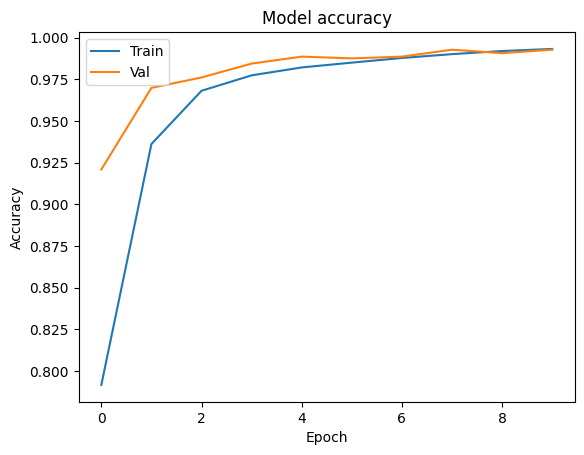

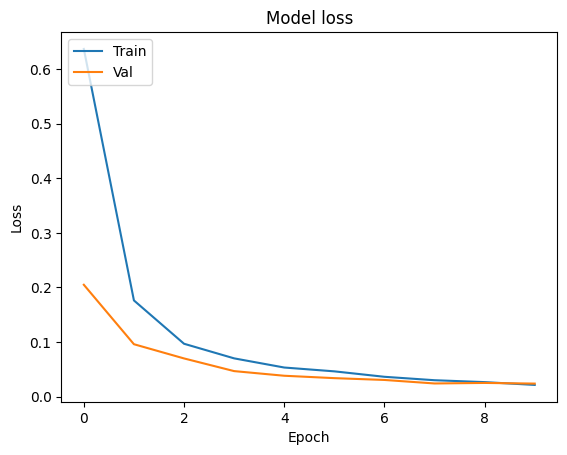

In [14]:
# Plot training & validation accuracy values
plt.plot(training_operation.history['accuracy'])
plt.plot(training_operation.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_operation.history['loss'])
plt.plot(training_operation.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

evaluating the performance of a trained model on test data. It prints the loss and accuracy that the model achieved on the test data. The loss is a measure of how well the model can estimate the target variables, while the accuracy is the proportion of correct predictions that the model made.

In [15]:
# Evaluate the model's performance on the test data. 
# The evaluate function returns the loss value and metrics values for the model in test mode.
# We set verbose=0 to avoid logging the detailed output during the evaluation.
loss, accuracy =  seq_lett_model.evaluate(X_test, y_test, verbose=0)

# Print the loss value that the model achieved on the test data.
# The loss value represents how well the model can estimate the target variables. Lower values are better.
print("Test loss:", loss)

# Print the accuracy that the model achieved on the test data.
# The accuracy is the proportion of correct predictions that the model made. Higher values are better.
print("Test accuracy:", accuracy)

Test loss: 0.04938802868127823
Test accuracy: 0.984375


### confusion matrix

In [ ]:
# Use the trained model to make predictions on the test data.
# The predict function returns the output of the last layer in the model, which in this case is the output of the softmax layer.
y_pred = seq_lett_model.predict(X_test)

# The output of the softmax layer is a vector of probabilities for each class. 
# We use the argmax function to find the index of the maximum probability, which gives us the predicted class.
y_pred = np.argmax(y_pred, axis = 1)

# Compute the confusion matrix to evaluate the accuracy of the classification.
# The confusion matrix is a table that is often used to describe the performance of a classification model.
# Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class.
# The 'normalize' parameter is set to 'true', which means the confusion matrix will be normalized by row (i.e., by the number of samples in each class).
confusionMatrix = confusion_matrix(y_test, y_pred, normalize = 'true')

# Create a ConfusionMatrixDisplay object from the confusion matrix.
# The display_labels parameter is set to the names of the classes.
disp = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ['T','B','Y','G'])

# Plot the confusion matrix.
disp.plot()

# Display the plot.
plt.show()

##### Precision, Recall e F1

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.97      0.99      0.98       400
           2       0.99      0.99      0.99       400
           3       0.99      0.97      0.98       400

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



### Extraction from the grid

In [27]:
!find  './manipulated_grids/' -name 'ROI_*' -exec rm {} \;

def capture_image_from_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imshow('Input', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return frame

def save_image(image, filename):
    cv2.imwrite(filename, image)

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

def find_largest_contour(contours):
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > max_area:
            max_area = area
            largest_contour = i
    return largest_contour

def extract_ROIs(contours, original):
    ROIs = []
    yt = None  # y-coordinate of the previous ROI
    n = 1  # count of ROIs with the same y-coordinate
    for i in contours:
        area = cv2.contourArea(i)
        if area > MIN_CONTOUR_AREA:
            x, y, w, h = cv2.boundingRect(i)
            if yt == y:
                n += 1
            else:
                yt = y
                n = 1
            ROI = original[y:y+h, x:x+w]
            ROIs.append(ROI)
    return ROIs, n

MIN_CONTOUR_AREA = 70 * 60

frame = capture_image_from_webcam()
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
save_image(frame, f'./grids/grid_{timestamp}.png')

image = cv2.imread(f'./grids/grid_{timestamp}.png')
thresh = preprocess_image(image)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = find_largest_contour(contours)
ROIs, n = extract_ROIs(contours, image.copy())

for i, ROI in enumerate(ROIs):
    save_image(ROI, f'./manipulated_grids/ROI_{i}.png')

cell calssifier

In [28]:
def preprocess_image(image_path):
    im = cv2.imread(image_path)
    if im is None:
        print(f"Error loading image: {image_path}")
        return None

    im = cv2.bitwise_not(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)
    im = cv2.resize(im, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)
    im = im.astype("float32") / 255
    im = np.reshape(im, (28, 28, 1))
    im = tf.expand_dims(im, axis=0)
    return im

seq_lett_model = tf.keras.models.load_model('seq_lett_model.keras')

l = []
for i in range(1, len(ROIs)):
    im = preprocess_image(f"./manipulated_grids/ROI_{i}.png")
    if im is not None:
        prediction = seq_lett_model.predict(im)
        max = np.where(prediction == np.amax(prediction))
        l.append(int(max[1][0]))

nrow = len(l) // n if n < len(l) else n // len(l)
nrow = int(nrow)

mat = np.array(list(reversed(l)))
grid = mat.reshape(nrow, n)

label_mapping = {0: 'T', 1: 'B', 2: 'Y', 3: 'G'}
show = np.vectorize(label_mapping.get)(grid)
print(show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[['B']
 ['G']
 ['G']
 ['B']
 ['B']
 ['B']]


## 4 Esecuzione. 
Si implementi un simulatore dell’esecuzione del piano di azioni calcolato, anche semplicemente attraverso una sequenza di immagini.